In [133]:
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from skimage import img_as_float32
from natsort import natsorted
from glob import glob
import numpy.linalg as npl
import numpy as np
import math as m
import imageio
import cv2

In [2]:
path_pairs = list(zip(
    natsorted(glob('./puzzle_corners/images/*.png')),
    natsorted(glob('./puzzle_corners/masks/*.png'))
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
masks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

C:\Users\Orwellian\AppData\Local\Temp\ipykernel_12576\2393374895.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
C:\Users\Orwellian\AppData\Local\Temp\ipykernel_12576\2393374895.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])


## Question 1

In [3]:
def get_puzzle_contour(mask):
    contours, heirarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    max_area_idx = 0
    max_area = cv2.contourArea(contours[max_area_idx])
    for i in range(1, len(contours)):
        area = cv2.contourArea(contours[i])

        if max_area < area:
            max_area = area
            max_area_idx = i

    return contours[max_area_idx]

def get_clockwise_contour(contour):
    if cv2.contourArea(contour, oriented=True) < 0:
        return contour[::-1]

### Question 1.3 - How `findContours()` works

In [91]:
display_imgs = np.random.randint(0, len(imgs), 3)
display_contours = [get_clockwise_contour(get_puzzle_contour(mask)) for mask in masks[display_imgs]]
print(display_imgs, [x.shape for x in display_contours])

[38 20 47] [(1126, 1, 2), (1137, 1, 2), (1239, 1, 2)]


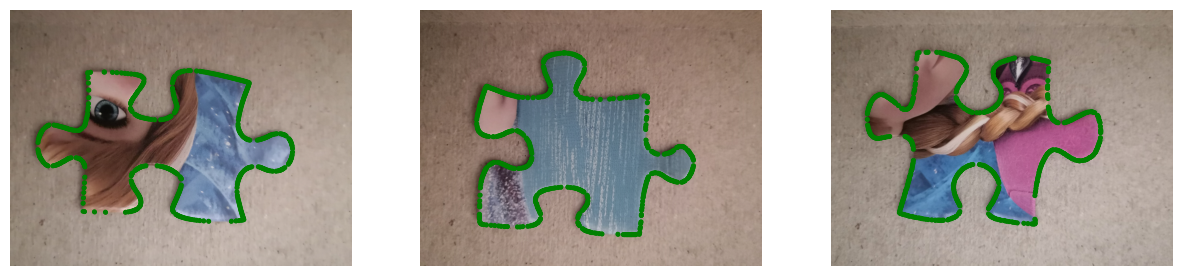

In [218]:
_, axes = plt.subplots(ncols=3, figsize=(15,5))
for i in range(3):
    contour = display_contours[i]

    for point in contour[:,0,:]:
        circle_point = pltpatches.Circle(point, 5, color='g')
        axes[i].add_patch(circle_point)

    axes[i].axis('off')
    axes[i].imshow(imgs[display_imgs[i]])

plt.show()

## Question 2

In [87]:
import json
with open("puzzle_corners/corners.json", "r") as f:
    names, corner_ratios = json.load(f)
    img_dims = np.array(masks[0].shape)
    corners = corner_ratios * img_dims[::-1] # swapped because numpy points are (y,x) and corner_ratios are (x,y)

### Question 2.1

In [85]:
def extract_sides(contour, corners):
    corner_dists = np.linalg.norm(contour - (corners), axis=-1)
    corner_indices =  np.sort(np.argmin(corner_dists, axis=-2))

    side_lengths = [
        corner_indices[1] - corner_indices[0],
        corner_indices[2] - corner_indices[1],
        corner_indices[3] - corner_indices[2],
        contour.shape[-3] - corner_indices[3] + corner_indices[0]
    ]
    side_contours = []

    for i in range(4):
        side_contour = np.take(contour, range(corner_indices[i], corner_indices[i] + side_lengths[i]), axis=-3, mode='wrap')
        side_contours.append(side_contour)

    return side_contours

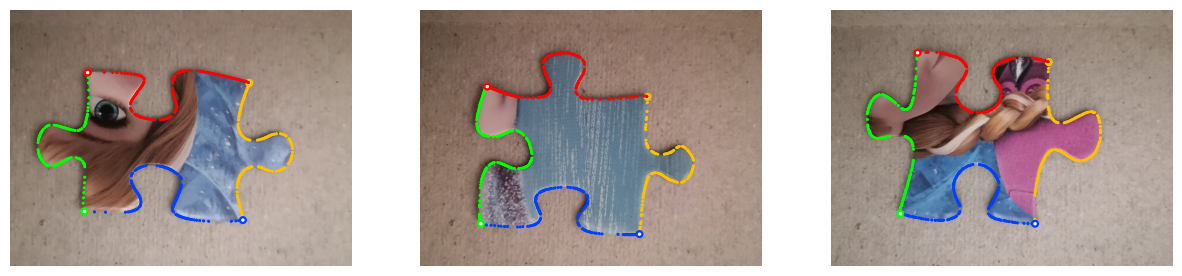

In [217]:
_, axes = plt.subplots(ncols=3, figsize=(15,5))
side_colours = [(255/255,192/255,0), (0,64/255,255/255), (0,255/255,0), (255/255,0,0)]
for i in range(3):
    side_contours = extract_sides(display_contours[i], corners[display_imgs[i]])

    # colours = ['green', 'red', 'orange', 'blue']
    for j, contour in enumerate(side_contours):
        for k, point in enumerate(contour[:,0,:]):
            circle_point = pltpatches.Circle(point, 2 if k != 0 else 10, color=side_colours[j])
            axes[i].add_patch(circle_point)

        center_corner_point = pltpatches.Circle(contour[0,0,:], 3, color='white')
        axes[i].add_patch(center_corner_point)

    axes[i].axis('off')
    axes[i].imshow(imgs[display_imgs[i]])

plt.show()

### Question 2.2

In [263]:
def transform_puzzle_side(contour):
    throughline = contour[-1] - contour[0]
    x_basis = np.array([1,0])
    angle_to_x = np.arctan2(throughline[0,0] * x_basis[1] - throughline[0,1] * x_basis[0], np.dot(throughline, x_basis))[0]
    angle_to_x = angle_to_x + (angle_to_x < 0) * 2 * m.pi

    rotation_matrix = np.array([
        [m.cos(angle_to_x), m.sin(angle_to_x)],
        [-m.sin(angle_to_x), m.cos(angle_to_x)],
    ])
    scale_factor = 2 / (contour[-1,0,0] - contour[0,0,0])

    transformed_contour = contour @ rotation_matrix
    scale_factor = 2 / (transformed_contour[-1,0,0] - transformed_contour[0,0,0])
    scale_matrix = np.identity(2) * scale_factor 
    translate_matrix = np.array([
        -1 - scale_factor * transformed_contour[0,0,0],
        -scale_factor * transformed_contour[-1,0,1]
    ])
    transformed_contour = transformed_contour @ scale_matrix + translate_matrix

    return transformed_contour

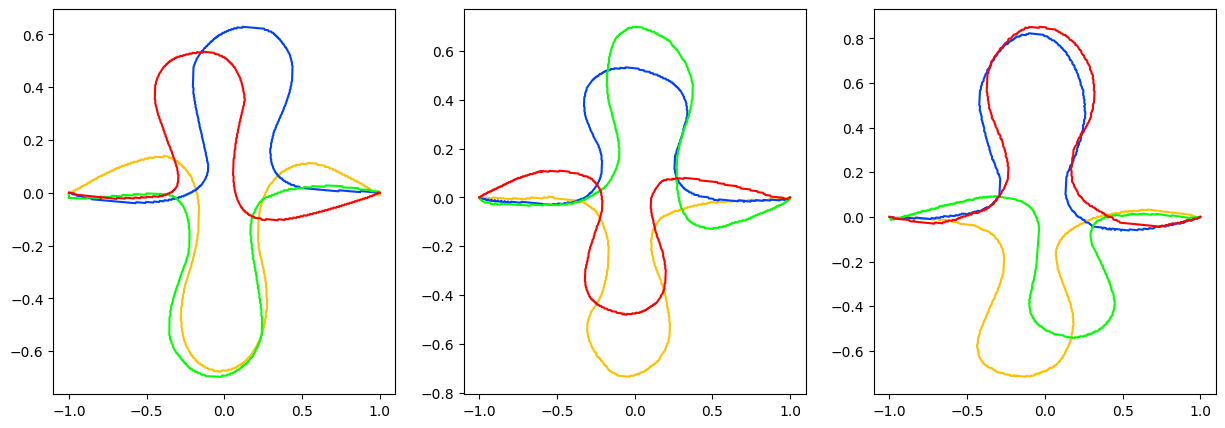

In [264]:
_, axes = plt.subplots(ncols=3, figsize=(15,5))
side_colours = [(255/255,192/255,0), (0,64/255,255/255), (0,255/255,0), (255/255,0,0)]
for i in range(3):
    side_contours = extract_sides(display_contours[i], corners[display_imgs[i]])

    for j, contour in enumerate(side_contours):
        transformed_contour = transform_puzzle_side(side_contours[j])
        axes[i].plot(transformed_contour[:,0,0], transformed_contour[:,0,1], c=side_colours[j])

    # axes[i].axis('off')

plt.show()

In [ ]:
def even_spaced_contour(contour, num_points=64):
    pass